# Bayesian Deep Learning 
#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Introducion

Our aim is to integrate Bayesian inference into performance demanding systems such as:

* Algorithmic trading
* Rendering/games engines
* Simulations platforms

keeping a good balance between research and production. 

Great packages are available:

* `python` : [PyMC3](https://docs.pymc.io), [BoTorch](https://botorch.org/), [hamiltorch](https://github.com/AdamCobb/hamiltorch)
* `Julia` : [AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl), [BAT.jl](https://github.com/bat/BAT.jl)
* `C++` : [STAN](https://mc-stan.org/users/interfaces/stan)

We rely on [PyTorch C++ frontend](https://pytorch.org/) for high performance linear algebra routines with `ATen`, automatic differentiation with `AutoGrad` and incorporating deep learning models via `TorchScript`. 

## Installation

We shall demonstrate some usage examples loading them as `PyTorch` extensions:
```cpp
#include <torch/extension.h>

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("generate_data", &generate_data, py::call_guard<py::gil_scoped_release>(),
          "Generate synthetic data");
    m.def("train_jit_module", &train_jit_module, py::call_guard<py::gil_scoped_release>(),
          "Likelihood training for a TorchScript module");
    m.def("sample_jit_module", &sample_jit_module, py::call_guard<py::gil_scoped_release>(),
          "Bayesian training for a TorchScript module");
    m.def("compute_posterior_mean_prediction", &compute_posterior_mean_prediction,
          py::call_guard<py::gil_scoped_release>(),
          "Compute posterior mean prediction");
    m.def("compute_bayes_predictions", &compute_bayes_predictions,
          py::call_guard<py::gil_scoped_release>(),
          "Compute Bayes sample predictions");
}
```

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [2]:
import torch
from torch import nn
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

%matplotlib inline

If you prefer dark plots you can run:

In [3]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

Now we need to build and load `C++17` extensions for `PyTorch`, here is a quick set-up:

In [4]:
!mkdir -p build
noa_location = '../..'

You get the extensions into `python` by calling `load`:

In [7]:
bnets = load(name='bayesian_nets',
             build_directory='./build',
             sources=[f'{noa_location}/docs/ghmc/bayesian_nets.cc'],
             extra_include_paths=[f'{noa_location}/src'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

## Frequentist vs Bayesian

Let's have a look at a simple regression task:

In [5]:
n_tr = 7
n_val = 300

x_train, y_train, x_val, y_val = bnets.generate_data(n_tr, n_val)

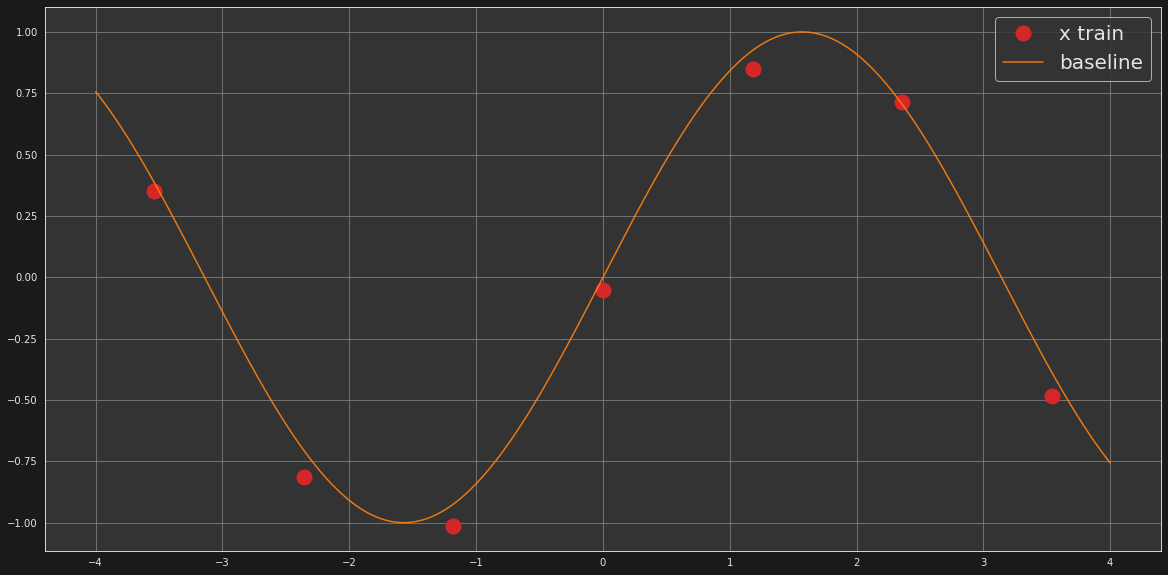

In [6]:
plt.figure(figsize=(20,10))
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='baseline')

plt.legend(fontsize=20)
plt.show()

```cpp
const auto x_val = torch::linspace(-4.f, 4.f, n_val).view({-1, 1});
const auto y_val = torch::sin(x_val);

const auto x_train = torch::linspace(-3.54f, 3.54f, n_tr).view({-1, 1});
const auto y_train = torch::sin(x_train) + 0.1f * torch::randn_like(x_train);
```

In [7]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(1, 10, bias = True)
        self.l2 = nn.Linear(10, 10, bias = True)
        self.l3 = nn.Linear(10, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        return x

net = Net()
jit_net = torch.jit.script(net)
jit_net.save('jit_net.pt')

In [8]:
[optim_params, adam_preds] = bnets.train_jit_module('jit_net.pt', x_train, y_train, x_val, 250)

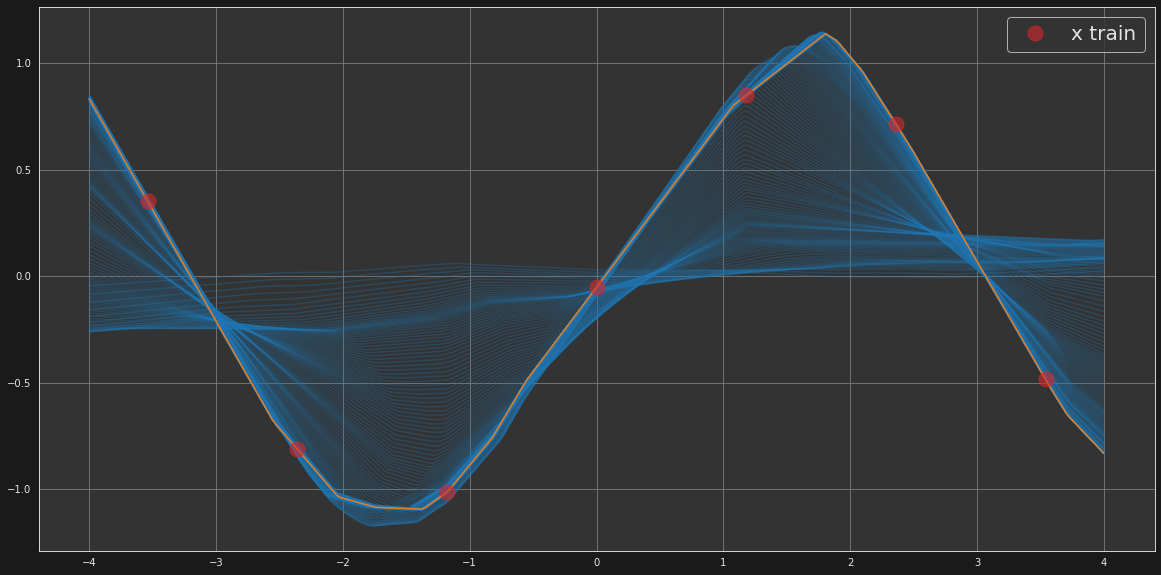

In [9]:
plt.figure(figsize=(20,10))
plt.plot(x_val.numpy(), adam_preds.numpy().squeeze().T, 'C0',alpha=0.3)
plt.plot(x_val.numpy(), adam_preds[-1].numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.show()

```cpp
auto net = torch::jit::load("jit_net.pt");
net.train();

auto loss_fn = torch::nn::MSELoss{};
auto optimizer = torch::optim::Adam{parameters(net), torch::optim::AdamOptions(0.005)};

auto adam_preds = std::vector<at::Tensor>{};
adam_preds.reserve(nepochs);

for (int i = 0; i < 250; i++) {
    optimizer.zero_grad();
    auto output = net({x_train}).toTensor();
    auto loss = loss_fn(output, y_train);
    loss.backward();
    optimizer.step();

    adam_preds.push_back(net({x_val}).toTensor().detach());
}
```

#### Frequentist point of view:

> What parameters of `net` give the highest probability of observing `{x_train, y_train}`?

To answer this question we start with an initial guess for the parameters and run the (stochastic) gradient descent optimisation to find a (local) maximum.

#### Bayesian point of view:
> What parameters of `net` are more likely now that we have observed `{x_train, y_train}` ?

To answer this question we start with an initial probability for the parameters - the PRIOR - and sample from the POSTERIOR given by the Bayes' rule:

\begin{equation}
\mathbb{P}(\textrm{parameters} | \textrm{data}) \propto \mathbb{P}(\textrm{data}|\textrm{parameters})*\mathbb{P}(\textrm{parameters})
\end{equation}

In [10]:
sample = bnets.sample_jit_module('jit_net.pt', 'ghmc_sample_bayesian_net.pt', x_train, y_train, torch.zeros_like(optim_params),
                                 0.01, 1.0, 300, 25, 0.001)
sample.shape

torch.Size([7149, 141])

In [11]:
posterior_mean_pred = bnets.compute_posterior_mean_prediction('jit_net.pt', x_val, sample, 2) 
bayes_pred_ = bnets.compute_bayes_predictions('jit_net.pt', x_val, sample) 
bayes_pred = bayes_pred_[-(bayes_pred_.shape[0] // 2):]

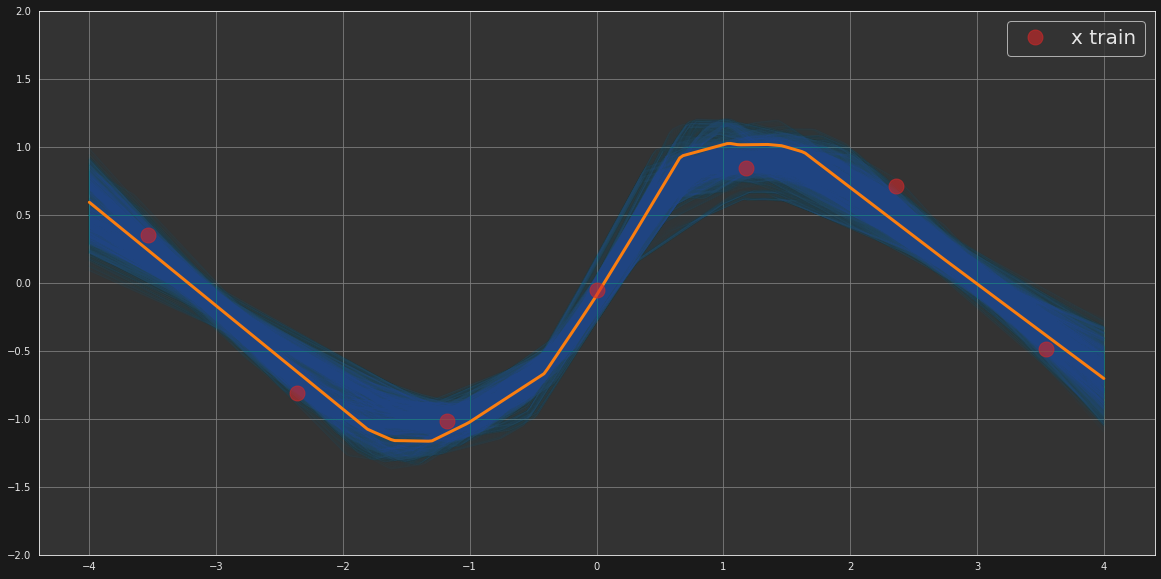

In [12]:
plt.figure(figsize=(20,10))
plt.plot(x_val.numpy(), bayes_pred.numpy().squeeze().T, 'C0',alpha=0.02)
plt.plot(x_val.numpy(), posterior_mean_pred.numpy().squeeze().T, 'C1',alpha=0.99, linewidth=3)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()

In [13]:
bayes_mean_pred = bayes_pred.mean(0)
bayes_std_pred = bayes_pred.std(0)
bayes_pstd_pred = bayes_mean_pred + bayes_std_pred
bayes_mstd_pred = bayes_mean_pred - bayes_std_pred

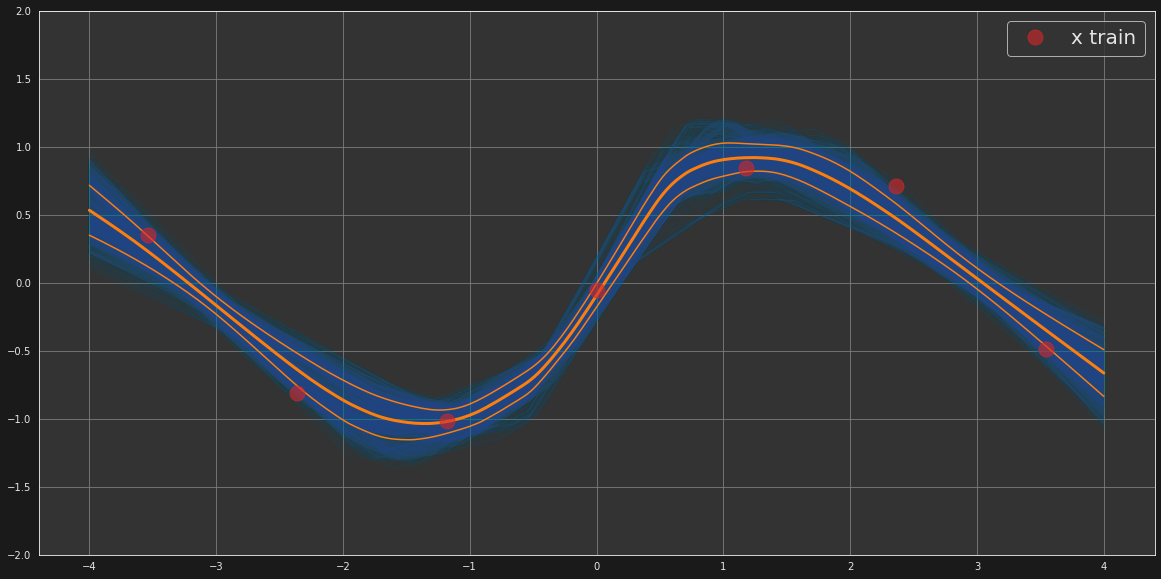

In [14]:
plt.figure(figsize=(20,10))
plt.plot(x_val.numpy(), bayes_pred.numpy().squeeze().T, 'C0',alpha=0.02)
plt.plot(x_val.numpy(), bayes_mean_pred.numpy().squeeze().T, 'C1',alpha=0.99, linewidth=3)
plt.plot(x_val.numpy(), bayes_pstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_val.numpy(), bayes_mstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()

<img src="hmc.png" />

Image credit: [Collin Carroll](https://colindcarroll.com/talk/hamiltonian-monte-carlo)

Note: if you are on Google Colab the image is located at `noa/docs/ghmc/hmc.png` 

HMC is an MCMC scheme where the parameters are lifted to a phase space and the simulation is evolved via Hamiltonian dynamics where the potential is given by the log probability density.

The Hamiltonian $H$ uses the log-probability density $\mathcal{L}(\vartheta)$ as potential, where $\vartheta \in \mathbb{R}^d$ denote the parameters which we augment with momentum coordinates $\chi \in \mathbb{R}^d$:
\begin{equation}
H(\vartheta,\chi) =  \frac{1}{2} \chi^t M^{-1}\chi + \frac{1}{2} \log \det(M) - \mathcal{L}(\vartheta)
\end{equation}

The library also implements Riemannian HMC (dependence of the metric on the parameters is allowed $M=M(\vartheta)$)  with an explicit symplectic integrator as in:

* M. Girolami et al., *Riemann manifold Langevin and Hamiltonian Monte Carlo methods*, J. Royal Stat. Soc. Series B (Stat. Meth.) (2011)
* A. Cobb et al., *Introducing an explicit symplectic integration scheme for Riemannian manifold Hamiltonian Monte-Carlo*, preprint arXiv:1910.06243 (2018)

This Hamiltonian is non-separable, and to avoid using an implicit integrator which is computationally heavy, one can rely on the explicit algorithm from:

* M. Tao, *Explicit high-order symplectic integrators for charged particles in general electromagnetic fields*. J. of Comp. Phys. 327 (2016)

In our example, we assume `y_train` has normal distribution with mean `net({x_train})` and variance `float model_variance`.

The prior distribution for the parameters is also normal with mean `vector<Tensor> prior_params` and `float params_variance`.
$$
\mathcal{L}(\vartheta) = -\frac{1}{2\sigma^2_M} \| \text{net}(\vartheta; X_{\text{train}})  - Y_{\text{train}}\|^2 -\frac{1}{2\sigma^2_P} \|\vartheta - \vartheta_{\text{prior}} \|^2
$$


```cpp
const auto log_prob_bnet = numerics::regression_log_probability(
            net, model_variance, prior_params, params_variance)(x_train, y_train);
```
The `regression_log_probability` utility returns a lambda that maps `vector<Tensor> parameters` to `tuple<Tensor, vector<Tensor>> log_prob_graph`.  The latter represents the value of the log probability together with the parameters that are now part of `AutoGrad` engine. You can differentiate it with `torch::autograd::grad`.

```cpp
const auto conf_bnet = Configuration<float>{}
            .set_max_flow_steps(max_flow_steps)
            .set_step_size(step_size);
```
This is just a holder for configurations in the algorithm. The two most important ones are `int max_flow_steps` which controls for how long you can evolve the Hamiltonian flow before switching of energy level. The`float step_size` controls discretisation in the numerical intergrator (just like the learning rate in SGD).

```cpp
const auto parameters = parameters(net)
const auto ham_dym = euclidean_dynamics(
            log_prob_bnet, 
            identity_metric_like(parameters(net)), 
            metropolis_criterion, 
            conf_bnet);
```
Here we create the most import component - the actual Hamiltonian dynamics with `euclidean_dynamics`. It returns a lambda which for given initial `vector<Tensor> parameters` and `optional<vector<Tensor>> momentum` computes the `HamiltonianFlow trajectory` in phase space made of:
```cpp
using ParametersFlow = vector<vector<Tensor>>;
using MomentumFlow = vector<vector<Tensor>>;
using EnergyLevel = vector<Tensor>;
using HamiltonianFlow = tuple<ParametersFlow, MomentumFlow, EnergyLevel>;
```
Besides `log_prob_bnet` and `conf_bnet` we discussed previously it needs a metric as `tuple<vector<Tensor>,vector<Tensor>> {spectrum, rotation}`.  This corresponds to the eigendecomposition of a global covariance matrix we expect the sample to have. In our case, we simply set it to the identity with the helper `identity_metric_like` following the shapes and layout of `vector<Tensor> parameters(net)`. In practice, this matrix is worked out during a burn run. 

We also provide `riemannian_dynamics`, which compared to `euclidean_dynamics` computes the metric locally based on the hessian of the log probability density. It is suitable for sampling from distributions exhibiting high curvature but requires more resources. 

Finally, you need to provide a termination criteria for the evolution: a lambda that takes `HamiltonianFlow trajectory` and outputs a `bool flag` whether to stop. You could simply let the flow evolve `max_flow_steps`. In practice, it is more efficient to stop it when it starts to explore a region of low probabiliy. This is precisely what `metropolis_criterion` gives us.

You could now sample from `log_prob_bnet` using `ham_dym` as you would in a SGD loop with an optimizer. But we provide you with a helper there as well:
```cpp
const auto bnet_sampler = sampler(ham_dym, full_trajectory, conf_bnet);
```
It takes a lambda which samples from `HamiltonianFlow trajectory`. Here `full_trajectory` takes everything. The strategy to use here depends on what your termination criteria was.

Given all that, you can run `bnet_sampler` providing some initial `vector<Tensor> parameters` and a number of `int iterations`.

```cpp
const auto net_params = parameters(net);
const auto samples = bnet_sampler(net_params, niter);
const auto result = stack(samples);
```
We flatten and concatenate `ParametersFlow samples` and return that to `python`.

## Bayesian inference for on-line learning

Bayesian algorithms are particularly great for on-line learning. Typically you will use SGD to train your model on a large data set and then use HMC for small streaming updates sampling around the optimal parameters. Let's update our data:

In [15]:
y_train[-1] += 1.0

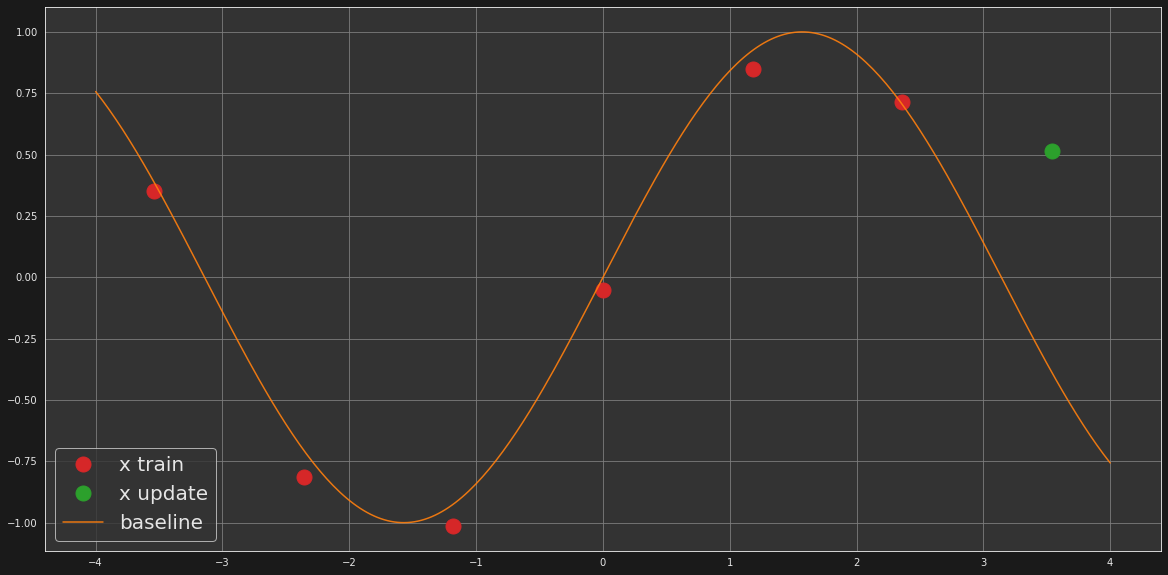

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x_train[:-1].numpy(), y_train[:-1].numpy(),'.C3',markersize=30, label='x train')
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='baseline')

plt.legend(fontsize=20, loc='lower left')
plt.show()

In [17]:
update_sample = bnets.sample_jit_module('jit_net.pt', 'ghmc_sample_update_bayesian_net.pt', x_train[-1:], y_train[-1:], optim_params,
                                0.1, 0.1, 20, 25, 0.001)
update_sample.shape

torch.Size([501, 141])

In [18]:
ubayes_pred = bnets.compute_bayes_predictions('jit_net.pt', x_val, update_sample)
ubayes_mean_pred = ubayes_pred.mean(0)
ubayes_std_pred = ubayes_pred.std(0)
ubayes_pstd_pred = ubayes_mean_pred + ubayes_std_pred
ubayes_mstd_pred = ubayes_mean_pred - ubayes_std_pred

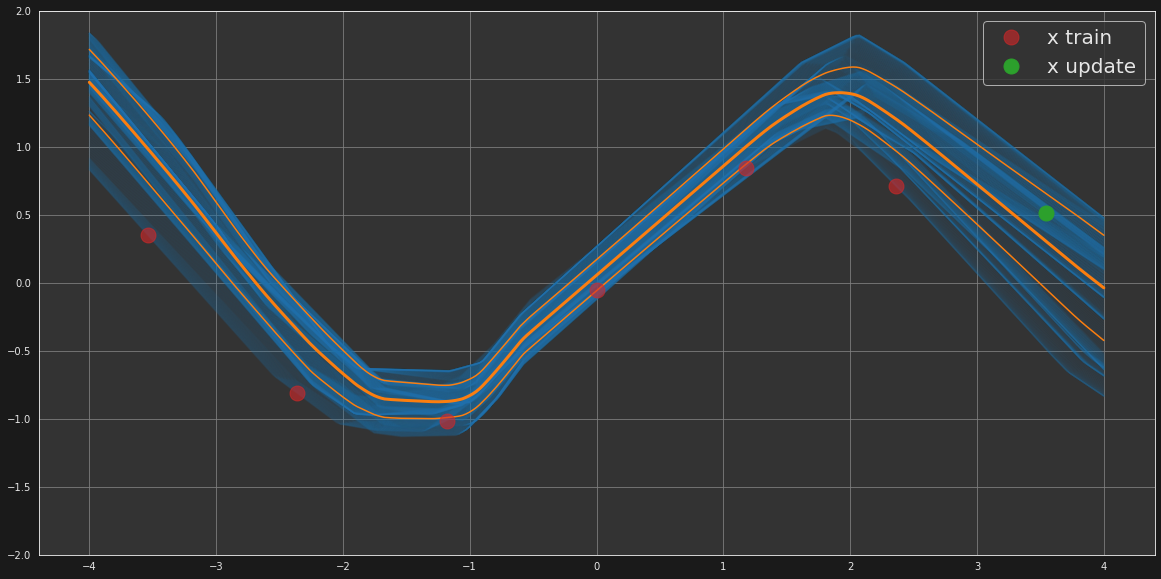

In [19]:
plt.figure(figsize=(20,10))
plt.plot(x_val.numpy(), ubayes_pred.numpy().squeeze().T, 'C0',alpha=0.1)
plt.plot(x_val.numpy(), ubayes_mean_pred.numpy().squeeze().T, 'C1',alpha=0.99, linewidth=3)
plt.plot(x_val.numpy(), ubayes_pstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_val.numpy(), ubayes_mstd_pred.numpy().squeeze().T, 'C1',alpha=0.99)
plt.plot(x_train[:-1].numpy(), y_train[:-1].numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')

plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()